# Working with timeseries forecasting with Pandas and Tensorflow RNN (LSTM) net

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
x = np.arange(3.1, 20, 0.2)

In [3]:
# Our function
y = (np.sin(2*x) * x) + np.random.rand(x.size) * 0.2

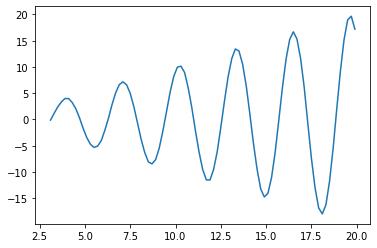

In [4]:
plt.plot(x, y)

In [5]:
len(x)

85

In [6]:
raw_dataset = pd.DataFrame.from_dict(dict(zip(x.tolist(), y.tolist())), orient='index').reset_index()
raw_dataset.columns = ['x', 'y']
raw_dataset = raw_dataset[["y", "x"]]
raw_dataset.head(5)

,y,x
0,-0.124871,3.1
1,1.168909,3.3
2,2.401286,3.5
3,3.350160,3.7
4,3.987952,3.9


In [7]:
def create_shifted_df(df,shift):
    shifted_df = pd.concat([df, df.shift(shift)[['y']]], axis=1)
    shifted_df.columns = ["y", "x", "y_"+str(shift)]
    shifted_df = shifted_df[["y_"+str(shift)]]
    return shifted_df.dropna()

In [8]:
test_df = raw_dataset
for i in range(1, 6):
    test_df = pd.concat([test_df, create_shifted_df(raw_dataset, i)], axis=1)

In [9]:
test_df = test_df.dropna()
test_df.head(5)

,y,x,y_1,y_2,y_3,y_4,y_5
5,3.962318,4.1,3.987952,3.350160,2.401286,1.168909,-0.124871
6,3.210431,4.3,3.962318,3.987952,3.350160,2.401286,1.168909
7,2.004500,4.5,3.210431,3.962318,3.987952,3.350160,2.401286
8,0.287463,4.7,2.004500,3.210431,3.962318,3.987952,3.350160
9,-1.706408,4.9,0.287463,2.004500,3.210431,3.962318,3.987952


In [10]:
test_df.shape

(80, 7)

In [11]:
test_df.tail(5)

,y,x,y_1,y_2,y_3,y_4,y_5
80,9.228813,19.1,2.088810,-5.442644,-11.786712,-16.264842,-18.003405
81,15.165686,19.3,9.228813,2.088810,-5.442644,-11.786712,-16.264842
82,18.962987,19.5,15.165686,9.228813,2.088810,-5.442644,-11.786712
83,19.659175,19.7,18.962987,15.165686,9.228813,2.088810,-5.442644
84,17.212695,19.9,19.659175,18.962987,15.165686,9.228813,2.088810


In [12]:
y = test_df.y
y.head(3)

5    3.962318
6    3.210431
7    2.004500
Name: y, dtype: float64

In [13]:
X = test_df.drop(['y'], axis=1)
X.columns = ["x","y1","y2","y3","y4","y5"]
X.head(3)

,x,y1,y2,y3,y4,y5
5,4.1,3.987952,3.350160,2.401286,1.168909,-0.124871
6,4.3,3.962318,3.987952,3.350160,2.401286,1.168909
7,4.5,3.210431,3.962318,3.987952,3.350160,2.401286


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [15]:
X_train.shape

(53, 6)

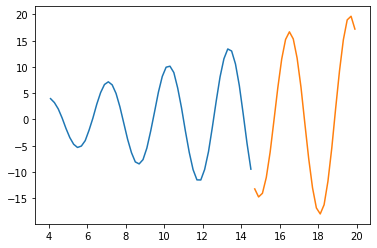

In [16]:
plt.plot(X_train.x, y_train)
plt.plot(X_test.x, y_test)

## Modeling

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

In [18]:
# [samples, time steps, features]
ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=X_train.drop(['x'], axis=1), # x was droped
                                                     targets=y_train,
                                                    sequence_length=1)
x, y = next(iter(ds))
x.shape[1:]

TensorShape([1, 5])

In [19]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(100, input_shape=x.shape[1:], activation='tanh', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            42400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='mean_squared_error', optimizer="adam", metrics="mean_absolute_error")

In [21]:
l_history = model.fit(x, y, epochs=1000)

Epoch 1/1000
2/2 [==============================] - 0s 1ms/step - loss: 46.9147 - mean_absolute_error: 5.8965
Epoch 2/1000
2/2 [==============================] - 0s 2ms/step - loss: 45.2114 - mean_absolute_error: 5.7856
Epoch 3/1000
2/2 [==============================] - 0s 3ms/step - loss: 44.6707 - mean_absolute_error: 5.7307
Epoch 4/1000
2/2 [==============================] - 0s 2ms/step - loss: 43.0708 - mean_absolute_error: 5.6477
Epoch 5/1000
2/2 [==============================] - 0s 2ms/step - loss: 42.6636 - mean_absolute_error: 5.6096
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 41.4857 - mean_absolute_error: 5.5141
Epoch 7/1000
2/2 [==============================] - 0s 2ms/step - loss: 40.1390 - mean_absolute_error: 5.4208
Epoch 8/1000
2/2 [==============================] - 0s 2ms/step - loss: 39.5589 - mean_absolute_error: 5.3677
Epoch 9/1000
2/2 [==============================] - 0s 2ms/step - loss: 38.1652 - mean_absolute_error: 5.2954
Epoch 10/1

Epoch 75/1000
2/2 [==============================] - 0s 2ms/step - loss: 4.4693 - mean_absolute_error: 1.4608
Epoch 76/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.9821 - mean_absolute_error: 1.4084
Epoch 77/1000
2/2 [==============================] - 0s 2ms/step - loss: 4.5932 - mean_absolute_error: 1.4048
Epoch 78/1000
2/2 [==============================] - 0s 2ms/step - loss: 4.0318 - mean_absolute_error: 1.4037
Epoch 79/1000
2/2 [==============================] - 0s 2ms/step - loss: 4.7114 - mean_absolute_error: 1.4450
Epoch 80/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.6205 - mean_absolute_error: 1.2838
Epoch 81/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.8986 - mean_absolute_error: 1.3208
Epoch 82/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.1982 - mean_absolute_error: 1.2303
Epoch 83/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.4773 - mean_absolute_error: 1.2748
Epoch 84/1

2/2 [==============================] - 0s 1ms/step - loss: 1.1932 - mean_absolute_error: 0.8374
Epoch 150/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.5030 - mean_absolute_error: 0.8580
Epoch 151/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.0682 - mean_absolute_error: 0.7510
Epoch 152/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.4749 - mean_absolute_error: 0.8758
Epoch 153/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.4966 - mean_absolute_error: 0.8339
Epoch 154/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.2693 - mean_absolute_error: 0.8522
Epoch 155/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.3882 - mean_absolute_error: 0.8906
Epoch 156/1000
2/2 [==============================] - 0s 1ms/step - loss: 1.3715 - mean_absolute_error: 0.8300
Epoch 157/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.0630 - mean_absolute_error: 0.7501
Epoch 158/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.7808 - mean_absolute_error: 0.6582
Epoch 223/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.8988 - mean_absolute_error: 0.6315
Epoch 224/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.7859 - mean_absolute_error: 0.6393
Epoch 225/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.5236 - mean_absolute_error: 0.5616
Epoch 226/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.8105 - mean_absolute_error: 0.6230
Epoch 227/1000
2/2 [==============================] - 0s 1ms/step - loss: 1.0579 - mean_absolute_error: 0.7409
Epoch 228/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.6301 - mean_absolute_error: 0.6197
Epoch 229/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.6031 - mean_absolute_error: 0.6193
Epoch 230/1000
2/2 [==============================] - 0s 2ms/step - loss: 1.2163 - mean_absolute_error: 0.7065
Epoch 231/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.3848 - mean_absolute_error: 0.4535
Epoch 296/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.7221 - mean_absolute_error: 0.5413
Epoch 297/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5232 - mean_absolute_error: 0.4898
Epoch 298/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5221 - mean_absolute_error: 0.4906
Epoch 299/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4811 - mean_absolute_error: 0.5303
Epoch 300/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.4927 - mean_absolute_error: 0.5445
Epoch 301/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5049 - mean_absolute_error: 0.4969
Epoch 302/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.6409 - mean_absolute_error: 0.5318
Epoch 303/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5279 - mean_absolute_error: 0.4739
Epoch 304/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.6122 - mean_absolute_error: 0.4745
Epoch 369/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4500 - mean_absolute_error: 0.4383
Epoch 370/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5520 - mean_absolute_error: 0.5061
Epoch 371/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3267 - mean_absolute_error: 0.4387
Epoch 372/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.4047 - mean_absolute_error: 0.4622
Epoch 373/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.7146 - mean_absolute_error: 0.5803
Epoch 374/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4314 - mean_absolute_error: 0.4621
Epoch 375/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.5497 - mean_absolute_error: 0.5202
Epoch 376/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.3908 - mean_absolute_error: 0.4224
Epoch 377/1000
2

2/2 [==============================] - 0s 1ms/step - loss: 0.2187 - mean_absolute_error: 0.3578
Epoch 442/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4945 - mean_absolute_error: 0.5182
Epoch 443/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2726 - mean_absolute_error: 0.4094
Epoch 444/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.5098 - mean_absolute_error: 0.4658
Epoch 445/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3591 - mean_absolute_error: 0.4252
Epoch 446/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4662 - mean_absolute_error: 0.4120
Epoch 447/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5254 - mean_absolute_error: 0.4987
Epoch 448/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3131 - mean_absolute_error: 0.3986
Epoch 449/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3196 - mean_absolute_error: 0.3662
Epoch 450/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.2913 - mean_absolute_error: 0.3978
Epoch 515/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3720 - mean_absolute_error: 0.4614
Epoch 516/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3767 - mean_absolute_error: 0.3896
Epoch 517/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4087 - mean_absolute_error: 0.4390
Epoch 518/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2931 - mean_absolute_error: 0.4108
Epoch 519/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2896 - mean_absolute_error: 0.3895
Epoch 520/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.5226 - mean_absolute_error: 0.4997
Epoch 521/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3606 - mean_absolute_error: 0.4205
Epoch 522/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4742 - mean_absolute_error: 0.5088
Epoch 523/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.4423 - mean_absolute_error: 0.4442
Epoch 588/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.3396 - mean_absolute_error: 0.4570
Epoch 589/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2703 - mean_absolute_error: 0.3977
Epoch 590/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2214 - mean_absolute_error: 0.3695
Epoch 591/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3010 - mean_absolute_error: 0.4020
Epoch 592/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3186 - mean_absolute_error: 0.4343
Epoch 593/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4741 - mean_absolute_error: 0.5025
Epoch 594/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3312 - mean_absolute_error: 0.4343
Epoch 595/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3661 - mean_absolute_error: 0.4361
Epoch 596/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.3597 - mean_absolute_error: 0.4706
Epoch 661/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2416 - mean_absolute_error: 0.3762
Epoch 662/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2984 - mean_absolute_error: 0.4296
Epoch 663/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5122 - mean_absolute_error: 0.4640
Epoch 664/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5763 - mean_absolute_error: 0.5369
Epoch 665/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3097 - mean_absolute_error: 0.4225
Epoch 666/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3420 - mean_absolute_error: 0.4465
Epoch 667/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.3386 - mean_absolute_error: 0.3783
Epoch 668/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2307 - mean_absolute_error: 0.3657
Epoch 669/1000
2

2/2 [==============================] - 0s 1ms/step - loss: 0.2223 - mean_absolute_error: 0.3502
Epoch 734/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3421 - mean_absolute_error: 0.4210
Epoch 735/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3376 - mean_absolute_error: 0.4179
Epoch 736/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3794 - mean_absolute_error: 0.4018
Epoch 737/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2870 - mean_absolute_error: 0.3970
Epoch 738/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.3779 - mean_absolute_error: 0.4812
Epoch 739/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.6427 - mean_absolute_error: 0.5739
Epoch 740/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.4149 - mean_absolute_error: 0.4559
Epoch 741/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.4216 - mean_absolute_error: 0.4495
Epoch 742/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.1807 - mean_absolute_error: 0.3379
Epoch 807/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.1831 - mean_absolute_error: 0.3361
Epoch 808/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.1755 - mean_absolute_error: 0.3111
Epoch 809/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3604 - mean_absolute_error: 0.4214
Epoch 810/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2198 - mean_absolute_error: 0.3351
Epoch 811/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.3047
Epoch 812/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.4750 - mean_absolute_error: 0.4773
Epoch 813/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2786 - mean_absolute_error: 0.3489
Epoch 814/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2791 - mean_absolute_error: 0.3524
Epoch 815/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.1527 - mean_absolute_error: 0.2667
Epoch 880/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2186 - mean_absolute_error: 0.3361
Epoch 881/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.3633 - mean_absolute_error: 0.4492
Epoch 882/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.1862 - mean_absolute_error: 0.3496
Epoch 883/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2505 - mean_absolute_error: 0.3629
Epoch 884/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2826 - mean_absolute_error: 0.3930
Epoch 885/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3687 - mean_absolute_error: 0.4489
Epoch 886/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.3561 - mean_absolute_error: 0.3879
Epoch 887/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2661 - mean_absolute_error: 0.3664
Epoch 888/1000
2

2/2 [==============================] - 0s 2ms/step - loss: 0.3326 - mean_absolute_error: 0.4096
Epoch 953/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2049 - mean_absolute_error: 0.3596
Epoch 954/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2346 - mean_absolute_error: 0.3873
Epoch 955/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.5216 - mean_absolute_error: 0.4898
Epoch 956/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.1805 - mean_absolute_error: 0.3265
Epoch 957/1000
2/2 [==============================] - 0s 2ms/step - loss: 0.2374 - mean_absolute_error: 0.3853
Epoch 958/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.3040 - mean_absolute_error: 0.4011
Epoch 959/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2186 - mean_absolute_error: 0.3440
Epoch 960/1000
2/2 [==============================] - 0s 1ms/step - loss: 0.2041 - mean_absolute_error: 0.3245
Epoch 961/1000
2

## Evaluation

In [22]:
y_pred = model.predict(X_test.drop('x', axis=1).to_numpy().reshape(X_test.shape[0],1,X_test.shape[1]-1)).reshape(X_test.shape[0])
y_pred

array([-11.72122   , -12.442765  , -12.225223  ,  -9.9905205 ,
        -5.6999345 ,   0.06958602,   5.9740067 ,  10.819136  ,
        13.489747  ,  14.286877  ,  13.442573  ,  10.853852  ,
         5.777013  ,  -0.35200733,  -6.993038  , -11.358009  ,
       -12.921861  , -13.132184  , -12.606976  ,  -9.856789  ,
        -4.782784  ,   2.0902026 ,   8.66982   ,  13.055402  ,
        14.771202  ,  14.975228  ,  13.976565  ], dtype=float32)

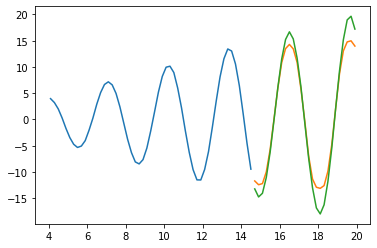

In [23]:
plt.plot(X_train.x, y_train)
plt.plot(X_test.x, y_pred)
plt.plot(X_test.x, y_test)

## Validate

In [24]:
x_validate = np.arange(3.1, 30, 0.2)
# Our function
y_validate = (np.sin(2*x_validate) * x_validate) + np.random.rand(x_validate.size) * 0.2
val_dataset = pd.DataFrame.from_dict(dict(zip(x_validate.tolist(), y_validate.tolist())), orient='index').reset_index()
val_dataset.columns = ['x', 'y']
val_dataset = val_dataset[["y", "x"]]
test_val = val_dataset
for i in range(1, 6):
    test_val = pd.concat([test_val, create_shifted_df(val_dataset, i)], axis=1)
test_val = test_val.dropna()
val_df = test_val.tail(40)
val_df.head(3)

,y,x,y_1,y_2,y_3,y_4,y_5
95,4.898767,22.1,-3.924479,-11.887521,-17.785135,-20.815269,-20.466465
96,13.070355,22.3,4.898767,-3.924479,-11.887521,-17.785135,-20.815269
97,19.149566,22.5,13.070355,4.898767,-3.924479,-11.887521,-17.785135


In [25]:
y_val_pred = model.predict(val_df.drop(['y','x'], axis=1).to_numpy().reshape(val_df.shape[0],1,val_df.shape[1]-2)).reshape(val_df.shape[0])
y_val_pred

array([  4.457142  ,  10.973263  ,  14.630899  ,  15.5891075 ,
        15.314498  ,  14.143888  ,  10.076083  ,   2.861817  ,
        -5.4964833 , -11.4880295 , -13.211377  , -13.50513   ,
       -13.720128  , -12.158465  ,  -8.30351   ,  -0.77033913,
         7.301753  ,  12.866608  ,  15.421714  ,  16.012804  ,
        15.484433  ,  14.107064  ,   8.884978  ,   0.6060156 ,
        -8.320333  , -12.78514   , -13.651317  , -13.607387  ,
       -13.67544   , -11.478414  ,  -7.004633  ,   1.8308969 ,
         9.803559  ,  14.354333  ,  15.7971325 ,  16.001352  ,
        15.539719  ,  13.613523  ,   7.046468  ,  -2.1136875 ],
      dtype=float32)

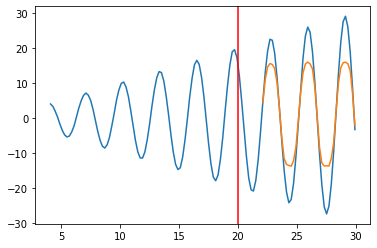

In [26]:
plt.plot(test_val.x, test_val.y)
plt.plot(val_df.x, y_val_pred)
plt.axvline(20, color='red')